In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Indian_Extent = pd.read_excel(filepath, sheet_name='Indian-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Indian_Extent)
fp.date_time(Indian_Extent)

,Extent,Date
0,376618.799,1979-01-01
1,211788.726,1979-02-01
2,262868.141,1979-03-01
3,698377.304,1979-04-01
4,1252407.727,1979-05-01
...,...,...
533,1520776.003,2023-06-01
534,2076164.165,2023-07-01
535,2731799.027,2023-08-01
536,3179384.692,2023-09-01


In [5]:
scaler = MinMaxScaler()
Indian_Extent['Extent'] = scaler.fit_transform(Indian_Extent['Extent'].values.reshape(-1, 1))

In [6]:
extent = Indian_Extent['Extent']
W_S=12
X,y = fp.df_to_X_y(extent, W_S)
X.shape, y.shape

((526, 12, 1), (526,))

In [7]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Indian_model/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 17s 214ms/step - loss: 0.2336 - root_mean_squared_error: 0.4833 - val_loss: 0.1382 - val_root_mean_squared_error: 0.3718
Epoch 2/50
53/53 [==============================] - 10s 191ms/step - loss: 0.1154 - root_mean_squared_error: 0.3397 - val_loss: 0.0808 - val_root_mean_squared_error: 0.2843
Epoch 3/50
53/53 [==============================] - 10s 187ms/step - loss: 0.0810 - root_mean_squared_error: 0.2846 - val_loss: 0.0629 - val_root_mean_squared_error: 0.2508
Epoch 4/50
53/53 [==============================] - 10s 197ms/step - loss: 0.0607 - root_mean_squared_error: 0.2463 - val_loss: 0.0441 - val_root_mean_squared_error: 0.2099
Epoch 5/50
53/53 [==============================] - 10s 189ms/step - loss: 0.0408 - root_mean_squared_error: 0.2020 - val_loss: 0.0229 - val_root_mean_squared_error: 0.1512
Epoch 6/50
53/53 [==============================] - 10s 188ms/step - loss: 0.0229 - root_mean_squared_error: 0.1514 - val_loss: 0.0111 

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

3.869189429283142 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

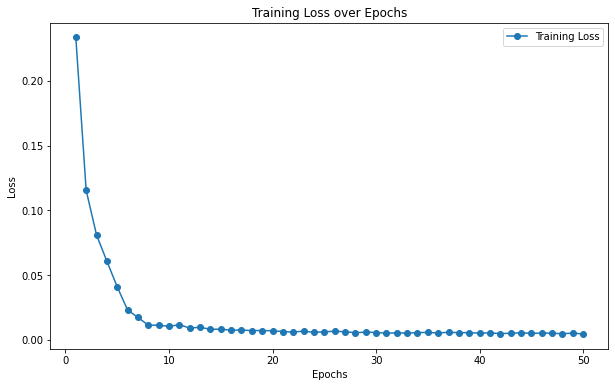

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

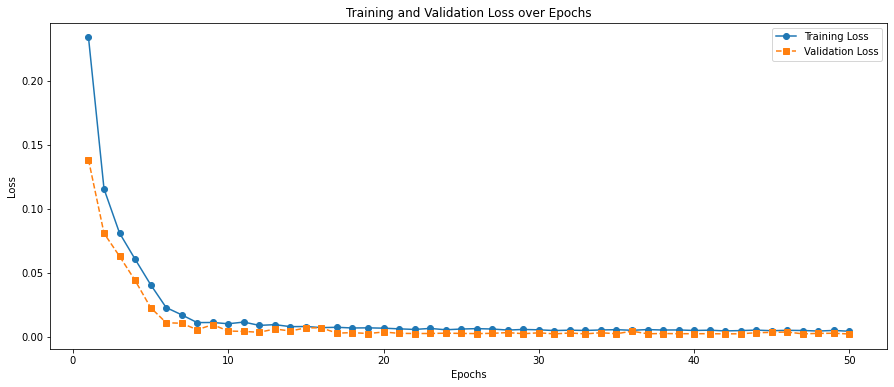

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [8]:
from tensorflow.keras.models import load_model
model1 = load_model('Indian_model/')

In [9]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 14ms/step


In [10]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.060625421210054896
MAE : 0.04935130522416995


In [11]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [12]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,1.190562e+06,1136509.923
1,1.848134e+06,1560879.775
2,2.528022e+06,2347500.604
3,3.108016e+06,3151724.833
4,3.497180e+06,3719188.531
5,3.659192e+06,3636501.241
6,3.070824e+06,2526913.818
7,1.514974e+06,1128752.378
8,4.621424e+05,522831.371
9,2.082407e+05,346601.304


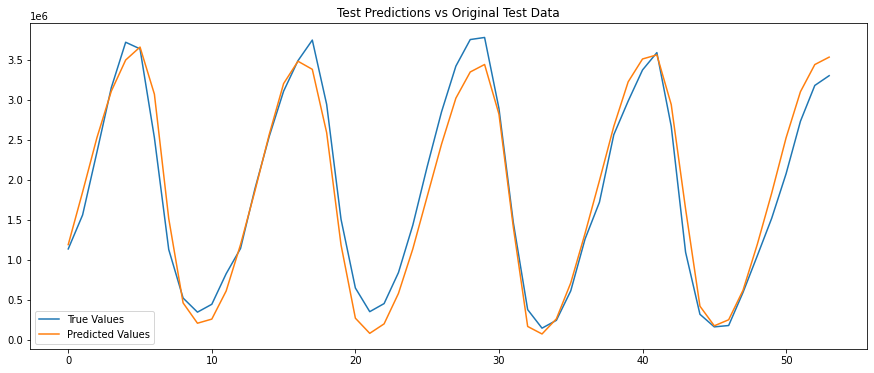

In [13]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [14]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 10ms/step


In [17]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

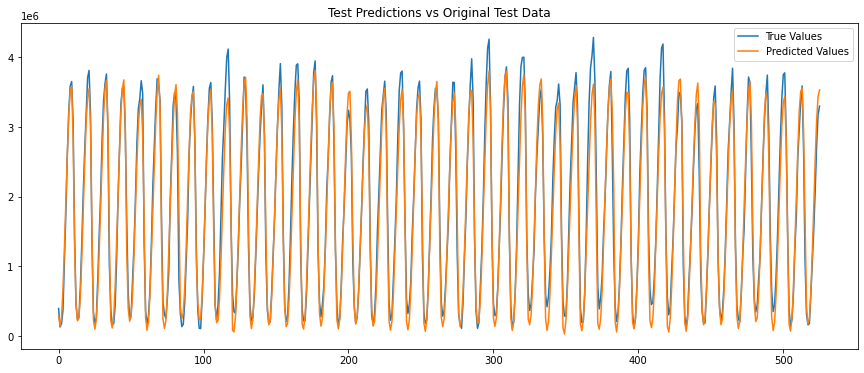

In [18]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()